In [9]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

# llm = ChatOllama(model="llama3.2", verbose=True)
llm = ChatGroq(model="llama-3.2-90b-vision-preview", verbose=True)


In [10]:
from typing import TypedDict
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langgraph.graph import add_messages


class State(TypedDict):
  messages: list[AnyMessage, add_messages]


In [11]:
from langchain_community.utilities import WikipediaAPIWrapper, DuckDuckGoSearchAPIWrapper
from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchRun, DuckDuckGoSearchResults

wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
search_tool = DuckDuckGoSearchResults()

research_tools = [wiki_tool, search_tool]
llm_with_search_call = llm.bind_tools(research_tools)


In [12]:
def react_research(state):
  return {
    'messages': [llm_with_search_call.invoke(state['messages'])]
  }


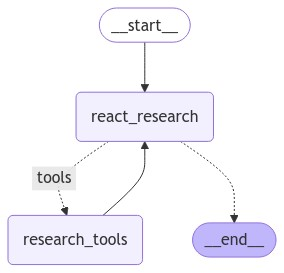

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)
builder.add_node(react_research)
builder.add_node(ToolNode(research_tools, name="research_tools"))

builder.add_edge(START, 'react_research')
builder.add_conditional_edges('react_research', tools_condition, {'tools': 'research_tools', END: END})
builder.add_edge('research_tools', 'react_research')

memory = MemorySaver()
graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [14]:
from langchain.callbacks.tracers import ConsoleCallbackHandler
config = {
  # "callbacks": [ConsoleCallbackHandler()],
  "configurable": {"thread_id": 1}
}
request = """
Aside from the Apple Remote, what other devices can control the program Apple Remote was originally designed to interact with?
"""
state = {
  "messages": [HumanMessage(content=request)]
}

response = graph.invoke(state)


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [7]:
for m in response['messages']:
  m.pretty_print()

================================== Ai Message ==================================

Here's an answer to your original user question based on the tool call responses:

Q: What are the main features of an Apple TV?

A: An Apple TV is a digital media player and microconsole that sends received media data to a TV or external display. It has various media services, including streaming media, TV Everywhere-based services, local media sources, and sports journalism and broadcasts. The second-generation and later models function only when connected via HDMI to an enhanced-definition or high-definition widescreen television.

Q: What is the purpose of a remote control?

A: A remote control is an electronic device used to operate another device from a distance, usually wirelessly. It allows operation of devices that are out of convenient reach for direct operation of controls and can be used to adjust various settings such as television channel, track number, and volume.

Q: How do I use iTunes Re

In [8]:
# for chunk in graph_stream:
#   chunk